In [1]:
import networkx as nx
import dwave_networkx as dnx
import random
import matplotlib.pyplot as plt
import pulp
import numpy as np

from lpSolver import solve
from uccgGenerator import tree_insertion, Graph
from plotNetwork import plotGraph, plotCoupling, plotGraphIS

In [2]:
def get_children(g, lambd=1):
    total = 0
    children = []
    n = len(g)
    for u in g.nodes:
        cg = Graph(g)
        if g.nodes[u]['in'] == True:
            cg.nodes[u]['in'] = False
            cg.prob = 1/(1+lambd)/n
            cg.move = f"remove {u}"
        else:
            neighbor_v = None
            num = 0
            for v in g.neighbors(u):
                if g.nodes[v]['in']:
                    num += 1
                    neighbor_v = v          
            if num == 0:
                cg.nodes[u]['in'] = True
                cg.prob = lambd/(1+lambd)/n
                cg.move = f"add {u}"
            elif num == 1:
                cg.nodes[u]['in'] = True
                cg.nodes[neighbor_v]['in'] = False
                cg.prob = lambd/(4*(1+lambd))/n
                cg.move = f"drag {u}, remove {neighbor_v}"
            else:
                continue
        total += cg.prob
        children.append(cg)
    g_stay = Graph(g)
    g_stay.prob = 1 - total
    g_stay.move = 'stay'
    children.append(g_stay)
    return children        

In [3]:
def hamming_dist(g1, g2):
    return [g1.nodes[u]['in'] != g2.nodes[u]['in'] for u in g1.nodes].count(True)

In [4]:
def generate_pair(n, m):
    g1 = tree_insertion(n, m)
    for u in g1.nodes:
        g1.nodes[u]['in'] = False
    for _ in range(200):
        g1 = random.choice(get_children(g1))

    g2 = random.choice(get_children(g1))
    while g2.move == 'stay':
        g2 = random.choice(get_children(g1))
    dist_orig = hamming_dist(g1, g2)
    delta = max([g1.degree(u) for u in g1])
    return g1, g2, dist_orig, delta

In [5]:
def compute_distance(g1, g2):
    g1_children = get_children(g1)
    g2_children = get_children(g2)
    l1, l2 = len(g1_children), len(g2_children)
    dists = np.zeros((l1, l2))
    for i in range(l1):
        for j in range(l2):
            dists[i][j] = hamming_dist(g1_children[i], g2_children[j])
    status, dist, joint_prob = solve(g1_children, g2_children, dists)
    return dist, g1_children, g2_children, dists, joint_prob

max degree 6, 1.025, 1


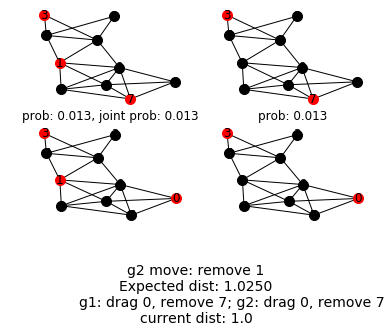

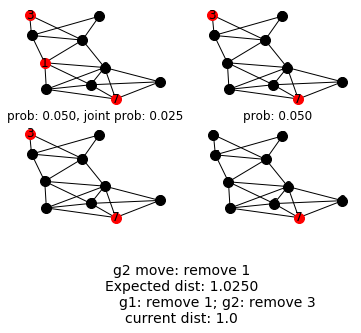

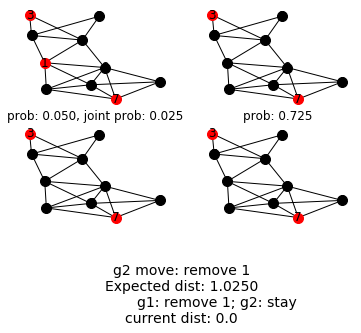

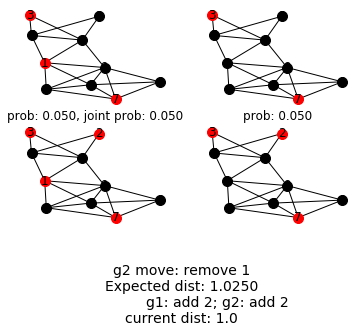

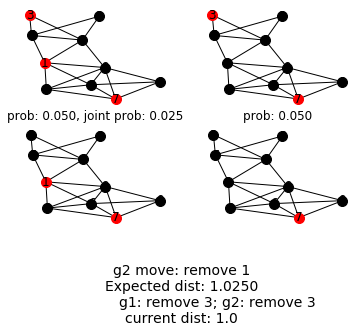

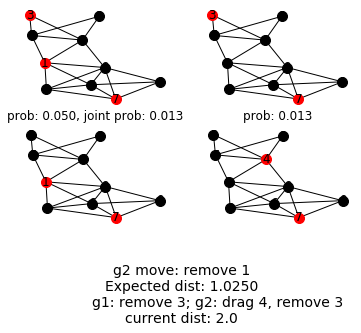

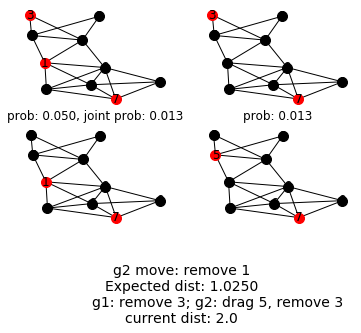

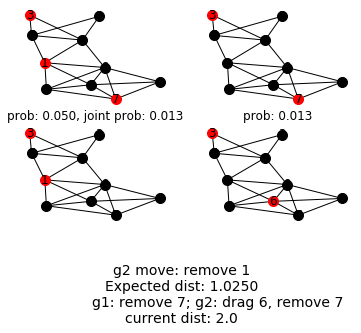

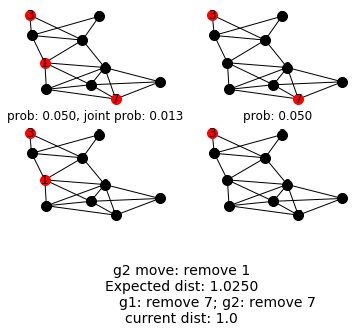

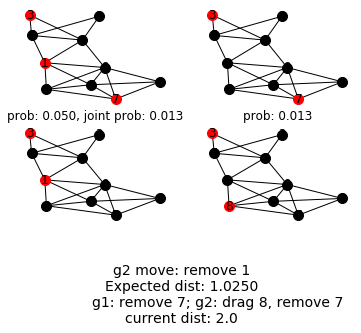

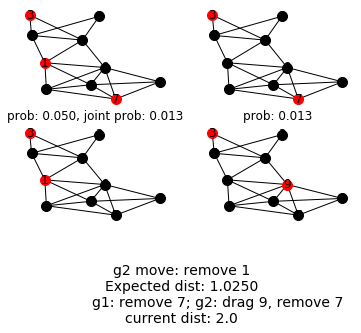

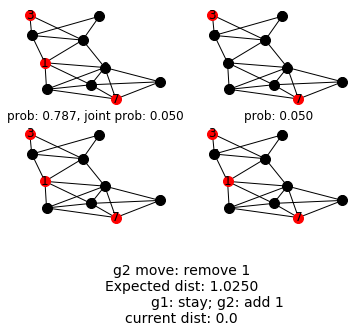

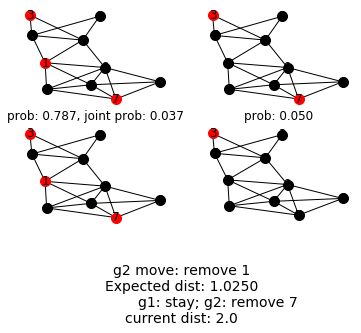

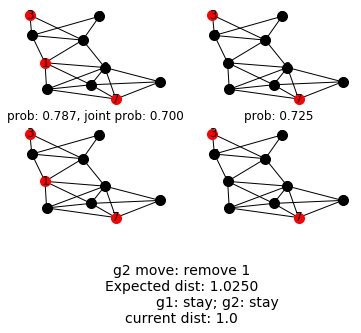

In [6]:
for _ in range(100):
    g1, g2, dist_orig, delta = generate_pair(10, 20)
    dist, g1_children, g2_children, dists, joint_prob = compute_distance(g1, g2)
    if dist - dist_orig > 0:
        pos = nx.kamada_kawai_layout(g1)
        print(f"max degree {delta}, {dist}, {dist_orig}")
        plotCoupling(g1, g2, g1_children, g2_children, dists, joint_prob, dist, pos=pos, plotfunc=plotGraphIS)
        break